<font size="5">Import Libraries</font>

In [31]:
# Use tensorflow 2.x version

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

<font size="5">Import Dataset</font>

In [43]:
def create_dataset(dataset, look_back=1):
	X = []
	Y = []
	
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		X.append(a)
		Y.append(dataset[i + look_back, 0])
	
	return np.array(X), np.array(Y)

np.random.seed(7)

<font size="4">Show Dataset</font>

In [53]:
dataset = data = pd.read_csv("./USDIDR_series.csv", index_col="Date")
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset[["USDIDR_Adj Close"]]
dataset = dataset.sort_index()
data = data.sort_index()

dataset

,USDIDR_Adj Close
Date,
2001-06-28,11448.000000
2001-06-29,11390.000000
2001-07-02,11320.000000
2001-07-03,11322.000000
2001-07-04,11365.000000
...,...
2021-08-24,14430.000000
2021-08-25,14448.700195
2021-08-26,14465.700195


<font size="4">Plot Dataset</font>

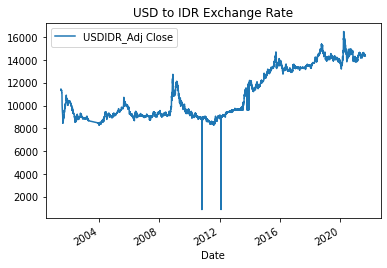

In [54]:
dataset.plot()
plt.title("USD to IDR Exchange Rate")
plt.show()

<font size="4">Average Closing Price</font>

In [45]:
averageClosingPrice = np.average(dataset)
print(f"Average Closing Price: {averageClosingPrice}")

Average Closing Price: 11067.873790581705


<font size="5">Data Preprocessing & Splitting</font>

<font size="4">Data Normalization (Min-Max Scaling)</font>

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print(dataset)

[[0.67619255]
 [0.67247858]
 [0.66799619]
 ...
 [0.86942813]
 [0.86837794]
 [0.86330005]]


<font size="4">Data Normalization (Min-Max Scaling)</font>

In [47]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

<font size="4">Average Closing Price (Train & Test Dataset)</font>

In [52]:
AverageTrainClosingPrice = np.average(scaler.inverse_transform(Y_train.reshape(-1, 1)))
AverageTestClosingPrice = np.average(scaler.inverse_transform(Y_test.reshape(-1, 1)))

print(f"Average Train Dataset Closing Price: {AverageTrainClosingPrice}")
print(f"Average Test Dataset Closing Price: {AverageTestClosingPrice}")

Average Train Dataset Closing Price: 10269.033240183144
Average Test Dataset Closing Price: 14259.966608176668


<font size="5">Model Creation & Training</font>

In [37]:
epochs = 10
model = Sequential()

model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.25, batch_size=1)

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

trainRMSE = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
testRMSE = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))

print()
print(f'Train RMSE: {trainRMSE}')
print(f'Test RMSE: {testRMSE}')

Epoch 1/10
3016/3016 [==============================] - 8s 2ms/step - loss: 0.0618 - val_loss: 0.0226
Epoch 2/10
3016/3016 [==============================] - 6s 2ms/step - loss: 0.0010 - val_loss: 0.0119
Epoch 3/10
3016/3016 [==============================] - 6s 2ms/step - loss: 7.1677e-04 - val_loss: 0.0064
Epoch 4/10
3016/3016 [==============================] - 6s 2ms/step - loss: 4.1403e-04 - val_loss: 0.0020
Epoch 5/10
3016/3016 [==============================] - 6s 2ms/step - loss: 3.8780e-04 - val_loss: 2.3727e-04
Epoch 6/10
3016/3016 [==============================] - 6s 2ms/step - loss: 4.1772e-04 - val_loss: 3.0973e-04
Epoch 7/10
3016/3016 [==============================] - 6s 2ms/step - loss: 2.2195e-04 - val_loss: 2.1934e-04
Epoch 8/10
3016/3016 [==============================] - 6s 2ms/step - loss: 2.7170e-04 - val_loss: 2.3096e-04
Epoch 9/10
3016/3016 [==============================] - 5s 2ms/step - loss: 2.5865e-04 - val_loss: 2.0043e-04
Epoch 10/10
3016/3016 [===========

<font size="4">Training & Validation Loss Curve</font>

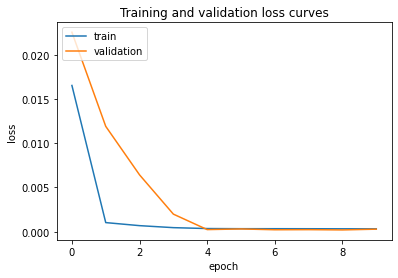

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<font size="5">Model Testing</font>

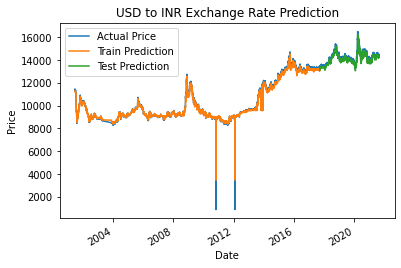

In [39]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[ : , : ] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, : ] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[ : , : ] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, : ] = testPredict

data["USDIDR_Adj Close"].plot(label="Actual Price")
plt.plot(data.index, trainPredictPlot, label="Train Prediction")
plt.plot(data.index, testPredictPlot, label="Test Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("USD to INR Exchange Rate Prediction")
plt.legend()
plt.show()